# InDebted DA Takehome - Keith Santos
I'll be doing an EDA to answer these 5 questions and hopefully gain more insights 

1. How should we handle the missing values for the columns age and customer_country?
2. What time of the day should we send our messages in each country?
3. What should be the preferred channel to use when communicating with customers?
4. What are the main metrics, dimensions and filters to be included in the dashboard?
5. What is the communications performance over time? What could be causing this behaviour?


In [96]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu

pd.set_option('display.max_rows', None)

In [4]:
df_csv = pd.read_csv('communications.csv')#, on_bad_lines='skip')
print(df_csv.shape)
df_csv.head()

(145941, 15)


,message_id,customer_id,sent_at,clicked,converted,client_id,gender,customer_country,age,created_at,client_name,product_type,client_country,channel,message_number
0,28d82c62db5989d9441351f58738c6a8,f13e966f9dc1e2aa7bffec6c9efa8e11,2021-01-04 10:03:16.376000+00:00,0,0,cfcd208495d565ef66e7dff9f98764da,F,NaN,51.0,2021-01-03 15:58:50.376000+00:00,SwanPay,BNPL,UK,SMS,1.0
1,0f98a1bbf7f2b66f420816a65c8d9b77,f13e966f9dc1e2aa7bffec6c9efa8e11,2021-01-12 08:34:09.376000+00:00,0,0,cfcd208495d565ef66e7dff9f98764da,F,NaN,51.0,2021-01-03 15:58:50.376000+00:00,SwanPay,BNPL,UK,SMS,2.0
2,97f9ed967d2334ce0b4ebfcfc9b5c25c,f13e966f9dc1e2aa7bffec6c9efa8e11,2021-01-19 08:58:11.376000+00:00,0,0,cfcd208495d565ef66e7dff9f98764da,F,NaN,51.0,2021-01-03 15:58:50.376000+00:00,SwanPay,BNPL,UK,Email,3.0
3,3d0615ca493d69e16265ab688495c134,f13e966f9dc1e2aa7bffec6c9efa8e11,2021-01-28 10:43:04.376000+00:00,0,0,cfcd208495d565ef66e7dff9f98764da,F,NaN,51.0,2021-01-03 15:58:50.376000+00:00,SwanPay,BNPL,UK,Email,4.0
4,3eb3a03a007bd1adf7482e6d95f7b942,f13e966f9dc1e2aa7bffec6c9efa8e11,2021-02-04 11:28:56.376000+00:00,0,0,cfcd208495d565ef66e7dff9f98764da,F,NaN,51.0,2021-01-03 15:58:50.376000+00:00,SwanPay,BNPL,UK,Email,5.0


In [5]:
df_csv.dtypes

message_id           object
customer_id          object
sent_at              object
clicked               int64
converted             int64
client_id            object
gender               object
customer_country     object
age                 float64
created_at           object
client_name          object
product_type         object
client_country       object
channel              object
message_number      float64
dtype: object

### 1. How should we handle the missing values for the columns age and customer_country?
- Tried to see if splitting the UTC from the datetime and doing the value counts would yield certain values that correspond to customer_country but didn't expect so much variation for UTC 

In [6]:
df_csv.isna().sum()

message_id              0
customer_id             0
sent_at                 0
clicked                 0
converted               0
client_id               0
gender              31676
customer_country    30146
age                 22020
created_at              0
client_name             0
product_type            0
client_country          0
channel                 0
message_number          0
dtype: int64

In [7]:
df_csv['customer_country'].value_counts()

UK    49146
CA    33911
NZ    32738
Name: customer_country, dtype: int64

In [8]:
#df_csv["age"].value_counts().sort_index()

UTC doesn't seem to be customer country specific and some NaNs share the same UTC with only 1 other customer country but don't think it's indicative + too much work to manually check if there are 2 matches

In [178]:
df_UTCtest = pd.DataFrame(columns=['customer_country','UTC'])
df_UTCtest['customer_country'] = df_csv['customer_country'].copy()
df_UTCtest['UTC'] = df_csv['sent_at'].str.split('.').str[1].copy()

In [179]:
df_UTCtest.fillna('None', inplace=True)
df_UTCtest.head()

,customer_country,UTC
0,None,376000+00:00
1,None,376000+00:00
2,None,376000+00:00
3,None,376000+00:00
4,None,376000+00:00


In [180]:
df_UTCtest['customer_country'].value_counts()

UK      49146
CA      33911
NZ      32738
None    30146
Name: customer_country, dtype: int64

Comparing the means and medians of the rows that have missing values and the ones that don't

In [188]:
df_missing_customercountries = df_csv.loc[df_csv['customer_country'].isna()].copy()
df_missing_customercountries.shape

(30146, 15)

In [189]:
df_complete_customercountries = df_csv.loc[df_csv['customer_country'].notnull()].copy()
df_complete_customercountries.shape

(115795, 15)

In [190]:
column_holder = 'customer_id'

print(df_missing_customercountries[column_holder].value_counts().mean())
print(df_csv[column_holder].value_counts().mean())
print(df_complete_customercountries[column_holder].value_counts().mean())

print(df_missing_customercountries[column_holder].value_counts().median())
print(df_csv[column_holder].value_counts().median())
print(df_complete_customercountries[column_holder].value_counts().median())

15.891407485503427
14.966772638703723
14.743442831678125
14.0
13.0
12.0


In [192]:
df_missing_valcounts = pd.DataFrame(columns=['messages_per_person'])
df_complete_valcounts = pd.DataFrame(columns=['messages_per_person'])

df_missing_valcounts["messages_per_person"] = df_missing_customercountries[column_holder].value_counts().values
df_complete_valcounts["messages_per_person"] = df_complete_customercountries[column_holder].value_counts().values

print(df_missing_valcounts.shape)
print(df_complete_valcounts.shape)

(1897, 1)
(7854, 1)


Mann Whitney U test shows a statistically significant p when comparing the samples of rows that have missing customer country vs rows that don't have missing customer country

In [193]:
_, pnorm = mannwhitneyu(df_missing_valcounts["messages_per_person"].sample(n=1500), df_complete_valcounts["messages_per_person"].sample(n=1500), method="asymptotic")
print(pnorm)

0.006066707733310536


<AxesSubplot: >

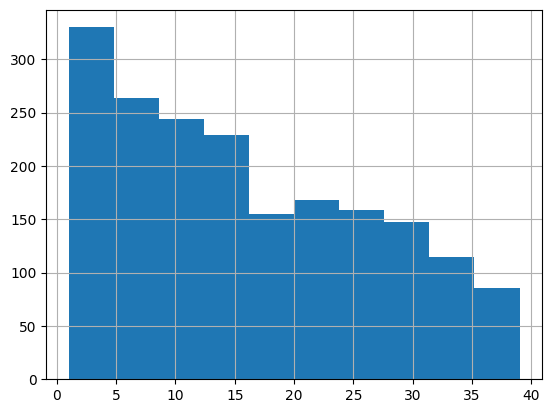

In [194]:
df_missing_valcounts["messages_per_person"].hist()

<AxesSubplot: >

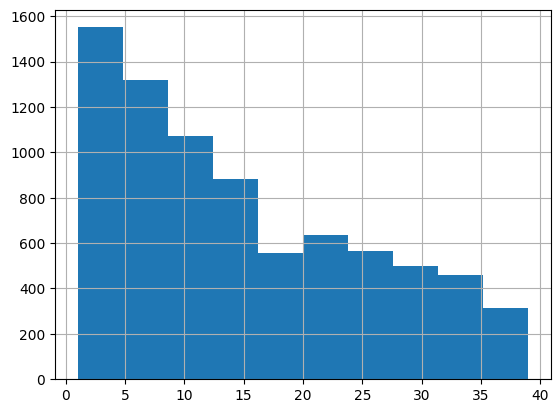

In [195]:
df_complete_valcounts["messages_per_person"].hist()